In [78]:
import os
import time
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from torch.utils.data import Dataset, DataLoader
from skimage.metrics import structural_similarity
from skimage.metrics import peak_signal_noise_ratio
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
import torchvision
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset
from torchvision.models import vgg16, vgg19
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure

from utils.Create_Dataset import PairedImageDataset
from utils.Pairing_Images import PairFinder

In [79]:
IMG_SHAPE = (256,256,3)
TARGET_SHAPE = (256,256,3)
BATCH_SIZE = 1
base_dir = "v_2/"
# Dataset Hyper Parameters
subset = "agri"
save_dataframe = "True"
s1_image_path = os.path.join(base_dir,subset + "/s1")
s2_image_path = os.path.join(base_dir,subset + "/s2")

In [80]:
image_dataset = PairedImageDataset(s1_dir=s1_image_path, s2_dir=s2_image_path, subset_name=subset, save_dataframe=save_dataframe)
dataloader = DataLoader(image_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"Total Instances = {len(image_dataset)}")

subset_indices = list(range(min(1000, len(image_dataset))))
subset_dataset = Subset(image_dataset, subset_indices)
subset_loader = DataLoader(subset_dataset, batch_size=1, shuffle=False)  # <--- Add this line

print(f"Sample Instances = {len(subset_dataset)}")


Total Instances = 4000
Sample Instances = 1000


In [81]:
for i,j in subset_dataset:
    print(i.shape,j.shape)
    break

torch.Size([3, 256, 256]) torch.Size([3, 256, 256])


# Model Instances

Provide to GPU

In [121]:
import torch
import torch.nn as nn

# ============== UNetGenerator ==============
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batch_norm=True):
        super(ConvBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        ]
        if use_batch_norm:
            layers.extend([
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            ])
        else:
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.conv_block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.conv_block(x)

class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_dropout=False):
        super(DeconvBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]
        if use_dropout:
            layers.append(nn.Dropout(0.5))
        self.conv_block = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.conv_block(x)

class Encoder(nn.Module):
    def __init__(self, in_channels=3):
        super(Encoder, self).__init__()
        self.enc1 = ConvBlock(in_channels, 64, use_batch_norm=False)
        self.enc2 = ConvBlock(64, 128)
        self.enc3 = ConvBlock(128, 256)
        self.enc4 = ConvBlock(256, 512)
        self.enc5 = ConvBlock(512, 512)
        self.enc6 = ConvBlock(512, 512)
        self.enc7 = ConvBlock(512, 512)
        self.enc8 = ConvBlock(512, 512, use_batch_norm=False)
    
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)
        e6 = self.enc6(e5)
        e7 = self.enc7(e6)
        e8 = self.enc8(e7)
        return [e1, e2, e3, e4, e5, e6, e7, e8]

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.dec1 = DeconvBlock(512, 512, use_dropout=True)
        self.dec2 = DeconvBlock(1024, 512, use_dropout=True)
        self.dec3 = DeconvBlock(1024, 512, use_dropout=True)
        self.dec4 = DeconvBlock(1024, 512)
        self.dec5 = DeconvBlock(1024, 256)
        self.dec6 = DeconvBlock(512, 128)
        self.dec7 = DeconvBlock(256, 64)
        self.dec8 = DeconvBlock(128, 64)
    
    def forward(self, encoder_outputs):
        e1, e2, e3, e4, e5, e6, e7, e8 = encoder_outputs
        d1 = self.dec1(e8)
        d2 = self.dec2(torch.cat([d1, e7], dim=1))
        d3 = self.dec3(torch.cat([d2, e6], dim=1))
        d4 = self.dec4(torch.cat([d3, e5], dim=1))
        d5 = self.dec5(torch.cat([d4, e4], dim=1))
        d6 = self.dec6(torch.cat([d5, e3], dim=1))
        d7 = self.dec7(torch.cat([d6, e2], dim=1))
        d8 = self.dec8(torch.cat([d7, e1], dim=1))
        return d8

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(UNetGenerator, self).__init__()
        self.encoder = Encoder(in_channels)
        self.decoder = Decoder()
        self.head = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.Tanh()
        )
    
    def forward(self, x):
        encoder_outputs = self.encoder(x)
        decoder_output = self.decoder(encoder_outputs)
        out = self.head(decoder_output)   # ✅ pass through head, not self.final
        return out



# ============== PatchDiscriminator ==============
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(PatchDiscriminator, self).__init__()
        
        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
    
    def forward(self, img_input, img_target):
        img_combined = torch.cat((img_input, img_target), 1)
        return self.model(img_combined)

In [122]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = UNetGenerator(in_channels=3, out_channels=2).to(device)
discriminator = PatchDiscriminator(in_channels=3).to(device)

# Metrics

In [123]:
def compute_metrics(generated_image, target_image):
    """
    Compute SSIM, PSNR, MSE, RMSE between generated and target images.
    Both inputs are PyTorch tensors in the range [-1, 1].
    """
    # Move to CPU, detach, and convert to numpy
    generated_image = generated_image.squeeze().detach().cpu().numpy()
    target_image = target_image.squeeze().detach().cpu().numpy()

    # Rescale from [-1, 1] to [0, 1]
    generated_image = (generated_image + 1) / 2.0
    target_image = (target_image + 1) / 2.0

    # Transpose from (C, H, W) to (H, W, C)
    generated_image = np.transpose(generated_image, (1, 2, 0))
    target_image = np.transpose(target_image, (1, 2, 0))

    # Clip values
    generated_image = np.clip(generated_image, 0, 1)
    target_image = np.clip(target_image, 0, 1)

    # Determine win_size
    min_height = min(generated_image.shape[0], target_image.shape[0])
    min_width = min(generated_image.shape[1], target_image.shape[1])
    win_size = min(min_height, min_width)
    win_size = win_size if win_size % 2 == 1 else win_size - 1  # make it odd

    # Ensure win_size is at least 3
    win_size = max(3, win_size)

    # Compute metrics
    ssim = structural_similarity(
        target_image, generated_image,
        channel_axis=-1, data_range=1.0,
        win_size=win_size
    )
    psnr = peak_signal_noise_ratio(target_image, generated_image, data_range=1.0)
    mse = mean_squared_error(target_image.flatten(), generated_image.flatten())
    rmse = np.sqrt(mse)

    return {
        "SSIM": ssim,
        "PSNR": psnr,
        "MSE": mse,
        "RMSE": rmse
    }

def evaluate_model(test_loader, generator, device):
    """
    Evaluate the model on the test set using image quality metrics.
    """
    ssim_scores, psnr_scores, mse_scores, rmse_scores = [], [], [], []

    generator.to(device)
    generator.eval()

    with torch.no_grad():
        for input_image, target_image in test_loader:
            input_image = input_image.to(device)
            target_image = target_image.to(device)

            # Ensure input is 4D (B, C, H, W)
            if input_image.dim() == 3:
                input_image = input_image.unsqueeze(0)
                target_image = target_image.unsqueeze(0)

            generated_image = generator(input_image)

            metrics = compute_metrics(generated_image, target_image)
            ssim_scores.append(metrics["SSIM"])
            psnr_scores.append(metrics["PSNR"])
            mse_scores.append(metrics["MSE"])
            rmse_scores.append(metrics["RMSE"])

    # Print averaged results
    print(f"SSIM: {np.mean(ssim_scores):.4f} | PSNR: {np.mean(psnr_scores):.2f} dB | MSE: {np.mean(mse_scores):.4f} | RMSE: {np.mean(rmse_scores):.4f}")



In [124]:
generator = UNetGenerator(in_channels=3, out_channels=3).to(device)
discriminator = PatchDiscriminator(in_channels=3).to(device)

LEARNING_RATE = 0.0002
BETA1 = 0.5
BETA2 = 0.999

generator_optimizer = torch.optim.Adam(
    generator.parameters(), 
    lr=LEARNING_RATE, 
    betas=(BETA1, BETA2)
)
discriminator_optimizer = torch.optim.Adam(
    discriminator.parameters(), 
    lr=LEARNING_RATE, 
    betas=(BETA1, BETA2)
)

print(f"✓ Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"✓ Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")


✓ Generator parameters: 54,539,203
✓ Discriminator parameters: 2,769,601


##DataLoaders

In [125]:
from torchvision import transforms

class SAROpticalDataset(Dataset):
    def __init__(self, root_dir, image_size=256):
        self.pairs = []
        self.transform_sar = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        ])
        self.transform_optical = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
        ])

        categories = ["agri", "barrenland", "grassland", "urban"]
        for cat in categories:
            s1_dir = os.path.join(root_dir, cat, "s1")
            s2_dir = os.path.join(root_dir, cat, "s2")
            if os.path.exists(s1_dir) and os.path.exists(s2_dir):
                for fname in os.listdir(s1_dir):
                    sar_path = os.path.join(s1_dir, fname)
                    opt_path = os.path.join(s2_dir, fname.replace("_s1_", "_s2_"))
                    if os.path.exists(opt_path):
                        self.pairs.append((sar_path, opt_path))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        sar_path, opt_path = self.pairs[idx]
        sar_img = Image.open(sar_path).convert("L")
        opt_img = Image.open(opt_path).convert("RGB")

        sar_tensor = self.transform_sar(sar_img)
        opt_tensor = self.transform_optical(opt_img)

        return sar_tensor, opt_tensor


In [126]:
dataset = SAROpticalDataset(root_dir="v_2", image_size=256)
print("Total pairs found:", len(dataset))

for i in range(min(5, len(dataset))):
    sar, opt = dataset[i]
    print(f"Pair {i}: SAR {sar.shape}, Optical {opt.shape}")


Total pairs found: 16000
Pair 0: SAR torch.Size([1, 256, 256]), Optical torch.Size([3, 256, 256])
Pair 1: SAR torch.Size([1, 256, 256]), Optical torch.Size([3, 256, 256])
Pair 2: SAR torch.Size([1, 256, 256]), Optical torch.Size([3, 256, 256])
Pair 3: SAR torch.Size([1, 256, 256]), Optical torch.Size([3, 256, 256])
Pair 4: SAR torch.Size([1, 256, 256]), Optical torch.Size([3, 256, 256])


In [127]:
sar, opt = dataset[0]
print(sar.shape, opt.shape)


torch.Size([1, 256, 256]) torch.Size([3, 256, 256])


In [128]:
from torch.utils.data import DataLoader, random_split

BATCH_SIZE = 16

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print(f"Train batches: {len(train_loader)}, Val batches: {len(val_loader)}")


Train batches: 800, Val batches: 200


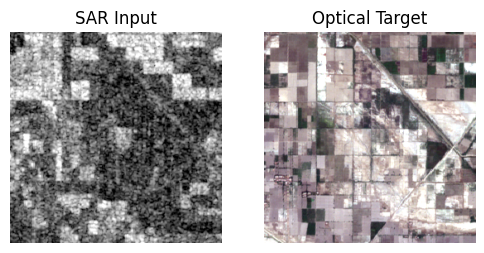

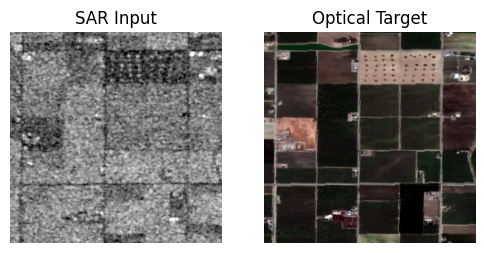

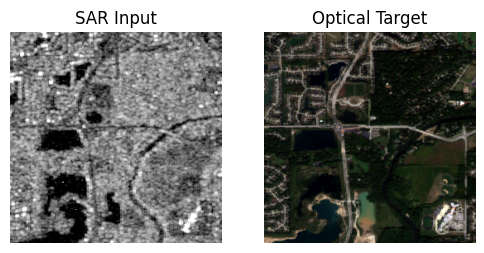

In [129]:
import matplotlib.pyplot as plt

def show_samples(loader, num_samples=3):
    sar_batch, opt_batch = next(iter(loader))
    for i in range(num_samples):
        sar = sar_batch[i][0].cpu().numpy()  # (H, W)
        opt = opt_batch[i].permute(1,2,0).cpu().numpy()  # (H, W, 3)

        plt.figure(figsize=(6,3))
        plt.subplot(1,2,1)
        plt.imshow(sar, cmap="gray")
        plt.title("SAR Input")
        plt.axis("off")

        plt.subplot(1,2,2)
        plt.imshow(opt)
        plt.title("Optical Target")
        plt.axis("off")

        plt.show()

show_samples(train_loader)


# Loss Functions

In [130]:
LAMBDA_L1 = 100
LAMBDA_PERCEPTUAL = 10

criterion_GAN = nn.BCEWithLogitsLoss()
criterion_L1 = nn.L1Loss()

# VGG for perceptual loss
include_perceptual = True
if include_perceptual:
    vgg = vgg19(pretrained=True).features[:36].to(device).eval()
    for param in vgg.parameters():
        param.requires_grad = False

def generator_loss(disc_output, fake_images, real_images, include_perc=False):
    valid = torch.ones_like(disc_output, device=device)
    adv_loss = criterion_GAN(disc_output, valid)
    l1_loss = criterion_L1(fake_images, real_images)
    
    if include_perc and include_perceptual:
        fake_features = vgg(fake_images)
        real_features = vgg(real_images)
        perc_loss = criterion_L1(fake_features, real_features)
        total_loss = adv_loss + LAMBDA_L1 * l1_loss + LAMBDA_PERCEPTUAL * perc_loss
        return total_loss, adv_loss, l1_loss, perc_loss
    else:
        total_loss = adv_loss + LAMBDA_L1 * l1_loss
        return total_loss, adv_loss, l1_loss

def discriminator_loss(disc_real, disc_fake):
    valid = torch.ones_like(disc_real, device=device)
    fake = torch.zeros_like(disc_fake, device=device)
    real_loss = criterion_GAN(disc_real, valid)
    fake_loss = criterion_GAN(disc_fake, fake)
    return (real_loss + fake_loss) / 2


/home/rohith/Downloads/SAR_Image_Colorization_Using_Deep_Learning_Algorithms-main/venv/lib64/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rohith/Downloads/SAR_Image_Colorization_Using_Deep_Learning_Algorithms-main/venv/lib64/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Perceptual loss

In [131]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T

# ------------------> Build VGG Feature Extractor <------------------
class VGG19FeatureExtractor(nn.Module):
    def __init__(self):
        super(VGG19FeatureExtractor, self).__init__()
        vgg = models.vgg19(pretrained=True).features
        self.feature_extractor = nn.Sequential(*list(vgg.children())[:12])  # Up to relu3_3
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, x):
        return self.feature_extractor(x)

# ------------------> Preprocess Function for VGG <------------------
def preprocess(img_tensor):
    """
    img_tensor: (B, 3, H, W), in [-1, 1]
    Output: normalized for VGG (mean-subtracted and scaled)
    """
    # Convert [-1, 1] to [0, 1]
    img_tensor = (img_tensor + 1) / 2.0
    normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    return normalize(img_tensor)

# ------------------> Perceptual Loss Class <------------------
class PerceptualLoss(nn.Module):
    def __init__(self, device):
        super(PerceptualLoss, self).__init__()
        self.vgg = VGG19FeatureExtractor().to(device)
        self.l1 = nn.L1Loss()

    def forward(self, y_true, y_pred):
        # Preprocess and move to same device as VGG
        y_true = preprocess(y_true).to(next(self.vgg.parameters()).device)
        y_pred = preprocess(y_pred).to(next(self.vgg.parameters()).device)

        # Extract VGG features
        features_true = self.vgg(y_true)
        features_pred = self.vgg(y_pred)

        # Compute L1 loss between features
        return self.l1(features_true, features_pred)

# ------------------> Instantiate on the Correct Device <------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
perceptual_loss = PerceptualLoss(device)


#### Generator Loss = l1_loss * lambda_l1 + perceptaul_loss * lambda

In [132]:
def generator_loss(disc_generated_output, gen_output, target, include_perceptual):
    real_labels = torch.ones_like(disc_generated_output)
    gan_loss = loss_object(disc_generated_output, real_labels)
    l1 = l1_loss_fn(gen_output, target)

    if include_perceptual:
        perc = perceptual_loss(target, gen_output)
        total_loss = gan_loss + (LAMBDA_L1 * l1) + (LAMBDA_PERC * perc)
        return total_loss, gan_loss, l1, perc
    else:
        total_loss = gan_loss + (LAMBDA_L1 * l1)
        return total_loss, gan_loss, l1

#### Discriminator Loss

In [133]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_labels = torch.ones_like(disc_real_output)
    fake_labels = torch.zeros_like(disc_generated_output)

    real_loss = loss_object(disc_real_output, real_labels)
    fake_loss = loss_object(disc_generated_output, fake_labels)

    total_disc_loss = real_loss + fake_loss
    return total_disc_loss


# Optimizers

In [134]:
GEN_LR = 0.0002
DISC_LR = 0.0002
BETA_1 = 0.5
BETA_2 = 0.999


In [135]:
generator_optimizer = Adam(generator.parameters(), lr=GEN_LR, betas=(BETA_1, BETA_2))
discriminator_optimizer = Adam(discriminator.parameters(), lr=DISC_LR, betas=(BETA_1, BETA_2))

# Train Step

In [136]:
def train_step(grayscale, color, include_perceptual=False):
    grayscale = grayscale.to(device)
    color = color.to(device)

    # Forward pass
    fake_color = generator(grayscale)

    disc_real_output = discriminator(grayscale, color)
    disc_fake_output = discriminator(grayscale, fake_color.detach())

    if include_perceptual:
        gen_loss, adv_loss, l1_loss, perc_loss = generator_loss(disc_fake_output, fake_color, color, include_perceptual)
    else:
        gen_loss, adv_loss, l1_loss = generator_loss(disc_fake_output, fake_color, color, include_perceptual)

    disc_loss = discriminator_loss(disc_real_output, disc_fake_output)

    # Backward pass and optimization
    generator_optimizer.zero_grad()
    gen_loss.backward(retain_graph=True)
    generator_optimizer.step()

    discriminator_optimizer.zero_grad()
    disc_loss.backward()
    discriminator_optimizer.step()

    if include_perceptual:
        return gen_loss, adv_loss, l1_loss, perc_loss, disc_loss
    else:
        return gen_loss, adv_loss, l1_loss, disc_loss


In [137]:
CHECKPOINT_DIR = 'checkpoints_Pix2PixPerceptual'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
loss_history = []

In [138]:
EPOCHS = 100
loss_history = []
include_metrics = True
include_perceptual = True

# Train Module 

In [139]:
loss_history = []
for epoch in range(1, EPOCHS + 1):
    start_time = time.time()

    # Accumulators
    gen_loss_total = adv_loss_total = l1_loss_total = perc_loss_total = disc_loss_total = 0
    num_batches = len(subset_loader)
    # Take one batch to debug

    for grayscale, color in subset_loader:
        grayscale, color = grayscale.to(device), color.to(device)

        if include_perceptual:
            gen_loss, adv_loss, l1_loss, perc_loss, disc_loss = train_step(grayscale, color, include_perceptual)
            perc_loss_total += perc_loss.item()
        else:
            gen_loss, adv_loss, l1_loss, disc_loss = train_step(grayscale, color, include_perceptual)
            perc_loss = torch.tensor(0.0)  # Placeholder if not used

        # Accumulate all losses
        gen_loss_total += gen_loss.item()
        adv_loss_total += adv_loss.item()
        l1_loss_total += l1_loss.item()
        disc_loss_total += disc_loss.item()

    # Epoch time
    elapsed_time = time.time() - start_time
    minutes, seconds = divmod(elapsed_time, 60)

    # Store loss values (averaged per batch)
    loss_history.append([
        gen_loss_total / num_batches,
        adv_loss_total / num_batches,
        l1_loss_total / num_batches,
        perc_loss_total / num_batches if include_perceptual else 0.0,
        disc_loss_total / num_batches
    ])

    # Print loss summary
    if include_perceptual:
        print(f"Epoch {epoch}/{EPOCHS} | Gen: {gen_loss_total / num_batches:.4f} | "
              f"Adv: {adv_loss_total / num_batches:.4f} | L1: {l1_loss_total / num_batches:.4f} | "
              f"Perc: {perc_loss_total / num_batches:.4f} | Disc: {disc_loss_total / num_batches:.4f} "
              f"| Time: {int(minutes)}m {int(seconds)}s")
    else:
        print(f"Epoch {epoch}/{EPOCHS} | Gen: {gen_loss_total / num_batches:.4f} | "
              f"Adv: {adv_loss_total / num_batches:.4f} | L1: {l1_loss_total / num_batches:.4f} | "
              f"Disc: {disc_loss_total / num_batches:.4f} | Time: {int(minutes)}m {int(seconds)}s")

    # Evaluate model every 10 epochs
    if epoch % 10 == 0 and include_metrics:
        print("-------------------------------------")
        evaluate_model(subset_loader, generator, device)
        print("-------------------------------------")

        # Save models
        torch.save(generator.state_dict(), f"Models/generator_epoch_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"Models/discriminator_epoch_{epoch}.pth")


Epoch 1/100 | Gen: 37.5411 | Adv: 4.7970 | L1: 0.3273 | Perc: 1.4949 | Disc: 0.1543 | Time: 1m 18s
Epoch 2/100 | Gen: 38.3169 | Adv: 6.9039 | L1: 0.3140 | Perc: 1.4415 | Disc: 0.0251 | Time: 1m 17s
Epoch 3/100 | Gen: 38.4143 | Adv: 7.4879 | L1: 0.3091 | Perc: 1.4315 | Disc: 0.0257 | Time: 1m 17s
Epoch 4/100 | Gen: 38.2248 | Adv: 7.6564 | L1: 0.3055 | Perc: 1.4244 | Disc: 0.0354 | Time: 1m 18s
Epoch 5/100 | Gen: 39.2677 | Adv: 9.0470 | L1: 0.3021 | Perc: 1.4199 | Disc: 0.0007 | Time: 1m 18s
Epoch 6/100 | Gen: 39.4443 | Adv: 9.7125 | L1: 0.2972 | Perc: 1.4182 | Disc: 0.0008 | Time: 1m 18s
Epoch 7/100 | Gen: 39.4355 | Adv: 10.5061 | L1: 0.2892 | Perc: 1.4210 | Disc: 0.0002 | Time: 1m 18s
Epoch 8/100 | Gen: 36.7758 | Adv: 8.8696 | L1: 0.2789 | Perc: 1.4244 | Disc: 0.0556 | Time: 1m 18s
Epoch 9/100 | Gen: 35.6994 | Adv: 8.4875 | L1: 0.2720 | Perc: 1.4207 | Disc: 0.0092 | Time: 1m 18s
Epoch 10/100 | Gen: 34.0217 | Adv: 7.4869 | L1: 0.2652 | Perc: 1.4201 | Disc: 0.0565 | Time: 1m 18s
--------

In [140]:
for epoch in range(101, 151):
    start_time = time.time()

    # Accumulators
    gen_loss_total = adv_loss_total = l1_loss_total = perc_loss_total = disc_loss_total = 0
    num_batches = len(subset_loader)

    for grayscale, color in subset_loader:
        grayscale, color = grayscale.to(device), color.to(device)

        if include_perceptual:
            gen_loss, adv_loss, l1_loss, perc_loss, disc_loss = train_step(grayscale, color, include_perceptual)
            perc_loss_total += perc_loss.item()
        else:
            gen_loss, adv_loss, l1_loss, disc_loss = train_step(grayscale, color, include_perceptual)
            perc_loss = torch.tensor(0.0)  # Placeholder if not used

        # Accumulate all losses
        gen_loss_total += gen_loss.item()
        adv_loss_total += adv_loss.item()
        l1_loss_total += l1_loss.item()
        disc_loss_total += disc_loss.item()

    # Epoch time
    elapsed_time = time.time() - start_time
    minutes, seconds = divmod(elapsed_time, 60)

    # Store loss values (averaged per batch)
    loss_history.append([
        gen_loss_total / num_batches,
        adv_loss_total / num_batches,
        l1_loss_total / num_batches,
        perc_loss_total / num_batches if include_perceptual else 0.0,
        disc_loss_total / num_batches
    ])

    # Print loss summary
    if include_perceptual:
        print(f"Epoch {epoch}/{EPOCHS} | Gen: {gen_loss_total / num_batches:.4f} | "
              f"Adv: {adv_loss_total / num_batches:.4f} | L1: {l1_loss_total / num_batches:.4f} | "
              f"Perc: {perc_loss_total / num_batches:.4f} | Disc: {disc_loss_total / num_batches:.4f} "
              f"| Time: {int(minutes)}m {int(seconds)}s")
    else:
        print(f"Epoch {epoch}/{EPOCHS} | Gen: {gen_loss_total / num_batches:.4f} | "
              f"Adv: {adv_loss_total / num_batches:.4f} | L1: {l1_loss_total / num_batches:.4f} | "
              f"Disc: {disc_loss_total / num_batches:.4f} | Time: {int(minutes)}m {int(seconds)}s")

    # Evaluate model every 10 epochs
    if epoch % 10 == 0 and include_metrics:
        print("-------------------------------------")
        evaluate_model(subset_loader, generator, device)
        print("-------------------------------------")

        # Save models
        torch.save(generator.state_dict(), f"Models/generator_epoch_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"Models/discriminator_epoch_{epoch}.pth")

Epoch 101/100 | Gen: 23.5718 | Adv: 15.7809 | L1: 0.0778 | Perc: 1.1279 | Disc: 0.0012 | Time: 1m 16s
Epoch 102/100 | Gen: 23.9297 | Adv: 16.1387 | L1: 0.0778 | Perc: 1.1264 | Disc: 0.0001 | Time: 1m 17s
Epoch 103/100 | Gen: 24.3393 | Adv: 16.5599 | L1: 0.0777 | Perc: 1.1250 | Disc: 0.0000 | Time: 1m 17s
Epoch 104/100 | Gen: 24.4566 | Adv: 16.7093 | L1: 0.0774 | Perc: 1.1229 | Disc: 0.0000 | Time: 1m 17s
Epoch 105/100 | Gen: 24.8885 | Adv: 17.1477 | L1: 0.0773 | Perc: 1.1211 | Disc: 0.0002 | Time: 1m 17s
Epoch 106/100 | Gen: 22.2103 | Adv: 14.5704 | L1: 0.0763 | Perc: 1.1183 | Disc: 0.0327 | Time: 1m 17s
Epoch 107/100 | Gen: 22.6440 | Adv: 15.0571 | L1: 0.0758 | Perc: 1.1160 | Disc: 0.0086 | Time: 1m 17s
Epoch 108/100 | Gen: 23.0589 | Adv: 15.4635 | L1: 0.0758 | Perc: 1.1148 | Disc: 0.0002 | Time: 1m 17s
Epoch 109/100 | Gen: 23.4626 | Adv: 15.8248 | L1: 0.0763 | Perc: 1.1142 | Disc: 0.0001 | Time: 1m 17s
Epoch 110/100 | Gen: 23.7308 | Adv: 16.1490 | L1: 0.0757 | Perc: 1.1115 | Disc: 0.

In [141]:
for epoch in range(151, 201):
    start_time = time.time()

    # Accumulators
    gen_loss_total = adv_loss_total = l1_loss_total = perc_loss_total = disc_loss_total = 0
    num_batches = len(subset_loader)

    for grayscale, color in subset_loader:
        grayscale, color = grayscale.to(device), color.to(device)

        if include_perceptual:
            gen_loss, adv_loss, l1_loss, perc_loss, disc_loss = train_step(grayscale, color, include_perceptual)
            perc_loss_total += perc_loss.item()
        else:
            gen_loss, adv_loss, l1_loss, disc_loss = train_step(grayscale, color, include_perceptual)
            perc_loss = torch.tensor(0.0)  # Placeholder if not used

        # Accumulate all losses
        gen_loss_total += gen_loss.item()
        adv_loss_total += adv_loss.item()
        l1_loss_total += l1_loss.item()
        disc_loss_total += disc_loss.item()

    # Epoch time
    elapsed_time = time.time() - start_time
    minutes, seconds = divmod(elapsed_time, 60)

    # Store loss values (averaged per batch)
    loss_history.append([
        gen_loss_total / num_batches,
        adv_loss_total / num_batches,
        l1_loss_total / num_batches,
        perc_loss_total / num_batches if include_perceptual else 0.0,
        disc_loss_total / num_batches
    ])

    # Print loss summary
    if include_perceptual:
        print(f"Epoch {epoch}/{200} | Gen: {gen_loss_total / num_batches:.4f} | "
              f"Adv: {adv_loss_total / num_batches:.4f} | L1: {l1_loss_total / num_batches:.4f} | "
              f"Perc: {perc_loss_total / num_batches:.4f} | Disc: {disc_loss_total / num_batches:.4f} "
              f"| Time: {int(minutes)}m {int(seconds)}s")
    else:
        print(f"Epoch {epoch}/{200} | Gen: {gen_loss_total / num_batches:.4f} | "
              f"Adv: {adv_loss_total / num_batches:.4f} | L1: {l1_loss_total / num_batches:.4f} | "
              f"Disc: {disc_loss_total / num_batches:.4f} | Time: {int(minutes)}m {int(seconds)}s")

    # Evaluate model every 10 epochs
    if epoch % 10 == 0 and include_metrics:
        print("-------------------------------------")
        evaluate_model(subset_loader, generator, device)
        print("-------------------------------------")

        # Save models
        torch.save(generator.state_dict(), f"Models/generator_epoch_{epoch}.pth")
        torch.save(discriminator.state_dict(), f"Models/discriminator_epoch_{epoch}.pth")

Epoch 151/200 | Gen: 26.0179 | Adv: 19.3184 | L1: 0.0669 | Perc: 1.0468 | Disc: 0.0000 | Time: 1m 17s
Epoch 152/200 | Gen: 24.1099 | Adv: 17.4211 | L1: 0.0668 | Perc: 1.0455 | Disc: 0.0227 | Time: 1m 17s
Epoch 153/200 | Gen: 24.3904 | Adv: 17.7448 | L1: 0.0664 | Perc: 1.0434 | Disc: 0.0004 | Time: 1m 17s
Epoch 154/200 | Gen: 23.3457 | Adv: 16.7012 | L1: 0.0663 | Perc: 1.0431 | Disc: 0.0371 | Time: 1m 17s
Epoch 155/200 | Gen: 22.6483 | Adv: 16.0101 | L1: 0.0663 | Perc: 1.0417 | Disc: 0.0002 | Time: 1m 17s
Epoch 156/200 | Gen: 22.8063 | Adv: 16.1941 | L1: 0.0660 | Perc: 1.0403 | Disc: 0.0002 | Time: 1m 17s
Epoch 157/200 | Gen: 22.9431 | Adv: 16.3446 | L1: 0.0659 | Perc: 1.0388 | Disc: 0.0001 | Time: 1m 18s
Epoch 158/200 | Gen: 23.1714 | Adv: 16.5813 | L1: 0.0658 | Perc: 1.0380 | Disc: 0.0001 | Time: 1m 17s
Epoch 159/200 | Gen: 23.5765 | Adv: 17.0193 | L1: 0.0655 | Perc: 1.0363 | Disc: 0.0001 | Time: 1m 17s
Epoch 160/200 | Gen: 23.9500 | Adv: 17.3937 | L1: 0.0655 | Perc: 1.0355 | Disc: 0.

In [142]:
import numpy as np

# Convert to numpy array and save
np.save("Pizx2pix_Percpetual_loss_history.npy", np.array(loss_history))

# Load it later:
# loss_history = np.load("loss_history.npy", allow_pickle=True).tolist()
